In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [17]:
file_path = 'D:\Desktop\lables.xlsx'
data_df = pd.read_excel(file_path, engine='openpyxl')

In [18]:
# 划分输入特征和标签
input_features = data_df.iloc[:, :4]
labels = data_df.iloc[:, -1] - 1

In [19]:
class MyDataset(Dataset):
    def __init__(self, input_features, labels, data_augmentation=False, sigma=0.1):
        self.input_features = input_features
        self.labels = labels
        self.data_augmentation = data_augmentation
        self.sigma = sigma

    def __len__(self):
        return len(self.input_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        original_input = torch.tensor(self.input_features.iloc[idx].values).float()
        if self.data_augmentation:
            input = original_input + self.sigma * torch.randn(original_input.size())
        else:
            input = original_input
        return input, torch.tensor(self.labels.iloc[idx]).float()

In [20]:
# dataset = MyDataset(input_features, labels)

In [20]:
input_features_train, input_features_test, labels_train, labels_test = train_test_split(input_features, labels, test_size=0.3, random_state=42)

In [21]:
batch_size = 4
# 更新数据集对象为训练集
train_dataset = MyDataset(input_features_train, labels_train, data_augmentation=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 创建测试集数据集和DataLoader
test_dataset = MyDataset(input_features_test, labels_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
class SimpleNN(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(4, 16)
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(8, 4)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        return x

In [23]:
def classification_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN().to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [26]:
num_epochs = 10000

In [27]:
def compute_loss(model, criterion, dataloader):
    losses = []
    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device).long()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
    return sum(losses) / len(losses)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device).long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # 验证阶段
    train_accuracy = classification_accuracy(model, train_dataloader)
    test_accuracy = classification_accuracy(model, test_dataloader)

    # 计算并添加训练集和测试集的损失到列表中
    train_loss = compute_loss(model, criterion, train_dataloader)
    test_loss = compute_loss(model, criterion, test_dataloader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.2%}, Test Accuracy: {test_accuracy:.2%}')

Epoch: 1/10000, Train Loss: 2.6288, Test Loss: 3.2843, Train Accuracy: 6.12%, Test Accuracy: 14.29%
Epoch: 2/10000, Train Loss: 1.8932, Test Loss: 2.7668, Train Accuracy: 59.18%, Test Accuracy: 42.86%
Epoch: 3/10000, Train Loss: 1.6587, Test Loss: 2.4815, Train Accuracy: 59.18%, Test Accuracy: 42.86%
Epoch: 4/10000, Train Loss: 1.7262, Test Loss: 2.1932, Train Accuracy: 59.18%, Test Accuracy: 42.86%
Epoch: 5/10000, Train Loss: 1.3983, Test Loss: 1.9486, Train Accuracy: 59.18%, Test Accuracy: 42.86%
Epoch: 6/10000, Train Loss: 1.3140, Test Loss: 1.7597, Train Accuracy: 59.18%, Test Accuracy: 42.86%
Epoch: 7/10000, Train Loss: 1.2717, Test Loss: 1.6323, Train Accuracy: 59.18%, Test Accuracy: 42.86%
Epoch: 8/10000, Train Loss: 1.2578, Test Loss: 1.5502, Train Accuracy: 59.18%, Test Accuracy: 42.86%
Epoch: 9/10000, Train Loss: 1.3203, Test Loss: 1.4819, Train Accuracy: 59.18%, Test Accuracy: 42.86%
Epoch: 10/10000, Train Loss: 1.3086, Test Loss: 1.4719, Train Accuracy: 59.18%, Test Accurac

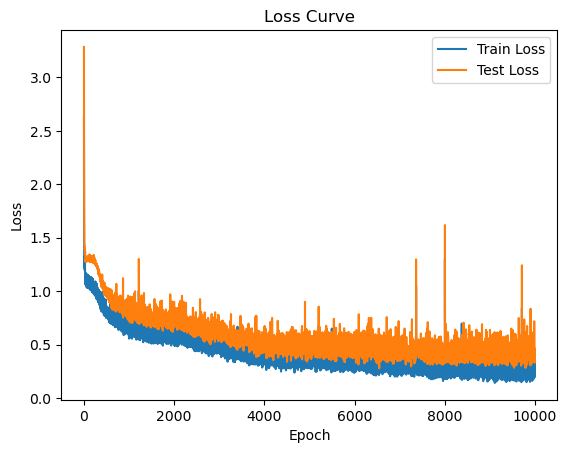

In [28]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()